In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils
from explainer.itemsets_miner import transform_intgrad_to_itemsets,gen_freq_feature_set
import explainer.integrad as integrad

from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from itertools import permutations

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
# Define a simple CNN model
class Net(nn.Module):
    def __init__(self,image_w=28,image_h=28,num_class=10,input_channel=1,output_channel=4,kernel=4,hidden_state=128):
        super(Net, self).__init__()
        self.output_channel = output_channel
        self.w = int((image_w - kernel + 1)/2)
        self.h = int((image_h - kernel + 1)/2)
        
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel)  # 1 input channel, 32 output channels, 5x5 kernel
       
        self.fc1 = nn.Linear(output_channel * self.w * self.h, hidden_state)  # Fully connected layer with 10 output classes
        self.fc2 = nn.Linear(hidden_state, num_class)
        
    def latent1(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, self.output_channel * self.w * self.h)
        return x
    
    def latent2(self,x):   
        x = self.latent1(x)
        x = F.relu(self.fc1(x))
        return x
        
    def forward(self, x):
#         x = self.latent1(x)
        x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def latent_representation(self,x):
        #x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [7]:
# Define data transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dpath = "../../data/"
trainset = torchvision.datasets.MNIST(root=dpath, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

# Define data transformations and load the MNIST test dataset
testset = torchvision.datasets.MNIST(root=dpath, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)


In [8]:
sum(trainset.targets==7)

tensor(6265)

In [9]:
# Initialize the model and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(50):  # Change the number of epochs as needed
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 400 == 399:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 400:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 400, Loss: 1.697
Epoch 1, Batch 800, Loss: 0.462
Epoch 2, Batch 400, Loss: 0.327
Epoch 2, Batch 800, Loss: 0.289
Epoch 3, Batch 400, Loss: 0.240
Epoch 3, Batch 800, Loss: 0.224
Epoch 4, Batch 400, Loss: 0.188
Epoch 4, Batch 800, Loss: 0.163
Epoch 5, Batch 400, Loss: 0.146
Epoch 5, Batch 800, Loss: 0.136
Epoch 6, Batch 400, Loss: 0.125
Epoch 6, Batch 800, Loss: 0.112
Epoch 7, Batch 400, Loss: 0.105
Epoch 7, Batch 800, Loss: 0.102
Epoch 8, Batch 400, Loss: 0.089
Epoch 8, Batch 800, Loss: 0.090
Epoch 9, Batch 400, Loss: 0.083
Epoch 9, Batch 800, Loss: 0.078
Epoch 10, Batch 400, Loss: 0.076
Epoch 10, Batch 800, Loss: 0.071
Epoch 11, Batch 400, Loss: 0.068
Epoch 11, Batch 800, Loss: 0.069
Epoch 12, Batch 400, Loss: 0.065
Epoch 12, Batch 800, Loss: 0.065
Epoch 13, Batch 400, Loss: 0.060
Epoch 13, Batch 800, Loss: 0.059
Epoch 14, Batch 400, Loss: 0.055
Epoch 14, Batch 800, Loss: 0.056
Epoch 15, Batch 400, Loss: 0.054
Epoch 15, Batch 800, Loss: 0.053
Epoch 16, Batch 400, Loss: 0

In [10]:
inputs.shape

torch.Size([32, 1, 28, 28])

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 98.55%


In [12]:
correct = 0
total = 0
X_train, X_train_raw = [],[]
y_train, pred_y_train = [],[]
train_reps = []
pred_prob_train = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        
        X_train_raw.append(inputs)
        X_train.append(model.latent2(inputs).detach())
        y_train.append(labels)        
        
        outputs = model(inputs).detach()
        train_reps.append(outputs) 
        predicted = torch.argmax(outputs,dim=1)
        pred_y_train.append(predicted) 
        pred_prob_train.append(torch.softmax(outputs,dim=1))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
X_train = torch.vstack(X_train)
X_train_raw = torch.vstack(X_train_raw)
train_reps = torch.vstack(train_reps)

y_train = torch.concat(y_train).numpy()
pred_y_train = torch.concat(pred_y_train).numpy()
pred_prob_train = torch.vstack(pred_prob_train).numpy()

print(f'Accuracy on the training set: {100 * correct / total:.2f}%')

Accuracy on the training set: 99.72%


In [14]:
# pred_prob_train = pred_prob_train.numpy()

# pred_prob_train[:,7]

y threshold 0.28734288


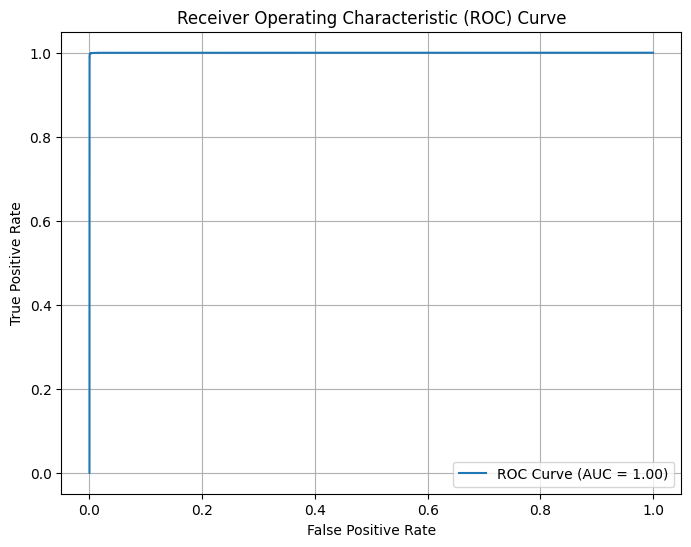

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy as sp


auc = roc_auc_score(y_train==7, pred_prob_train[:,7])
fpr, tpr, thresholds = roc_curve(y_train==7, pred_prob_train[:,7])
y_thd = thresholds[np.argmax(tpr - fpr)]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

In [16]:
(pred_y_train==7).sum(),((pred_y_train==7)&(y_train==7)).sum()/(y_train==7).sum()

(6274, 0.9969672785315243)

In [17]:
recall = ((pred_y_train==7)&(y_train==7)).sum()/(y_train==7).sum()
precision = ((pred_y_train==7)&(y_train==7)).sum()/(pred_y_train==7).sum()
recall,precision

(0.9969672785315243, 0.9955371373924131)

In [18]:
f1 = 2*recall*precision/(recall+precision)
f1

0.9962516947124971

In [19]:
baselines = eutils.gen_intgrad_baselines(X_train,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train,y_train,size_per_class=1000)

In [20]:
len(baselines)

10

In [21]:
### specify target class
c = 7 

### calc int grads for target class
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,C=10,target_dim=c)
y_int_g = torch.abs(int_g/z_shift[:,c].reshape(-1,1))

int_g.shape,y_int_g.shape

(torch.Size([9000, 128]), torch.Size([9000, 128]))

In [22]:
### find threshold for int grads
thds = np.linspace(0.0001,0.1,1000)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]<=1:
        break
thd = f_n[-1][0] 
thd

(0.0001, tensor(8))
(0.0002, tensor(2))
(0.00030000000000000003, tensor(2))
(0.0004, tensor(1))


0.0004

In [23]:
### find frequent feature set
itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=1000,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[45.0] 8926.0
[45.0, 21.0] 8750.0
[45.0, 21.0, 106.0] 8538.0
[45.0, 21.0, 106.0, 67.0] 8204.0
[45.0, 21.0, 106.0, 67.0, 6.0] 7850.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0] 7475.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0] 7036.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0] 6648.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0] 6243.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0] 5743.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0] 5398.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0, 20.0] 5047.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0, 20.0, 34.0] 4717.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0, 20.0, 34.0, 18.0] 4271.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0, 20.0, 34.0, 18.0, 78.0] 3979.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69.0, 115.0, 29.0, 61.0, 20.0, 34.0, 18.0, 78.0, 122.0] 3536.0
[45.0, 21.0, 106.0, 67.0, 6.0, 16.0, 89.0, 69

In [34]:
reload(rlm)

<module 'explainer.rule_pattern_miner' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/rule_pattern_miner.py'>

In [37]:
### search rule sets

min_support = 4000   
num_grids = 20
max_depth = 2

### specify result path
prefix = "./results/mnist/c"+str(c)+"_sp"+str(min_support)
if not os.path.exists(prefix):
    os.mkdir(prefix)

rule_list = rlm.gen_rule_list_for_one_target(X_train.numpy(),fids,pred_y_train==c,y=y_train,c=c,sort_by="cond_prob_target",
                                                            min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                                            local_x=None,feature_types=None,search="ordered",
                                                            verbose=False)

build_rule_tree
init rule tree
search rule for feature 44
check potential rule 44 7.312121300478261 7.657766241776316 13.22705078125 5204
add rule [] 44 [7.312121300478261, 44]
search rule for feature 20
check potential rule 20 1.041134401081315 0.0 0.8056594949019583 4310
add rule [44] 20 [1.041134401081315, 20]


In [38]:
rule_list

[{'rules': [(44, '>=', 7.657766241776316),
   (20, '>=', 0.0),
   (20, '<=', 0.8056594949019583)],
  'cond_prob_target': 0.7960556844547564,
  'support': 4310,
  'cond_prob_y': 0.794431554524362,
  'ratio_y': 0.5465283320031923}]

In [26]:
r1 = rule_list[0]["rules"]
seen = set()
keys = [r[0] for r in r1 if not (r[0] in seen or seen.add(r[0]))] ##keep the order of rules

### merge rules of the same feature
rdict = {}
for key in keys:
    for r in r1:
        if r[0] == key:
            rdict[key] = rdict.get(key,[])
            rdict[key].append(r)
rdict

{44: [(44, '>=', 7.657766241776316)],
 114: [(114, '>=', 0.0), (114, '<=', 4.361351213957134)]}

/var/folders/1w/jwcgd35x0rg1yln4sl7szvf80000gn/T/ipykernel_33525/2035654857.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  imgs = X_train_raw[ids]


[(44, '>=', 7.657766241776316)] support tensor(5204)


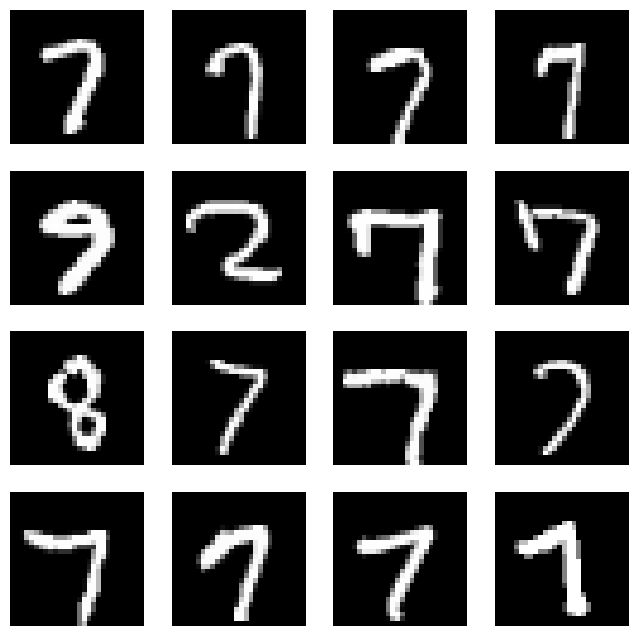

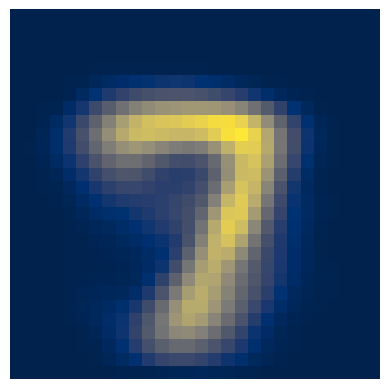

[(114, '>=', 0.0), (114, '<=', 4.361351213957134)] support tensor(33538)


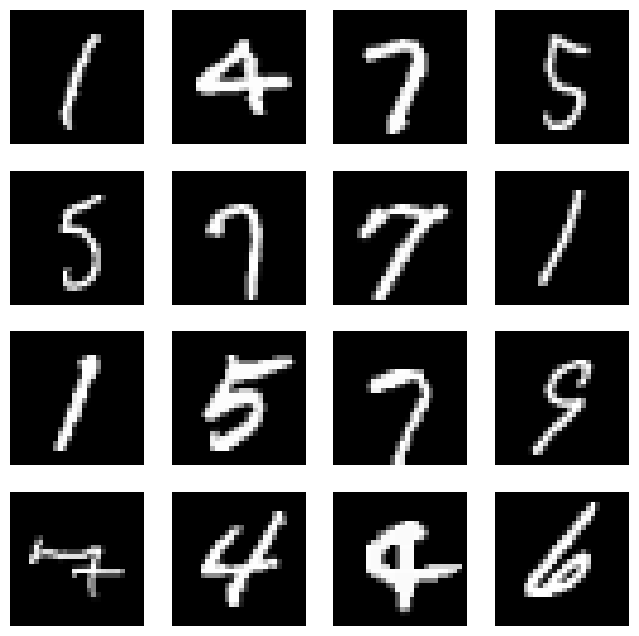

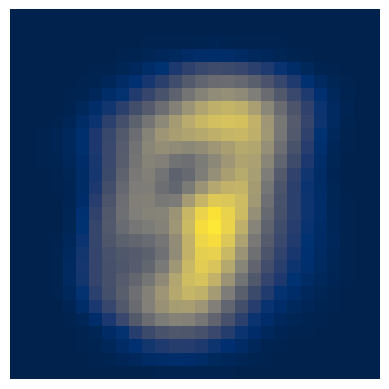

In [27]:
### visualize rules in the top rule set

tot_img = []
file_type = ".svg"

for kk,fid in enumerate(keys):
    rs = rdict[fid]
    ids = np.ones(len(X_train)).astype(bool)
    for r in rs:
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
    imgs = X_train_raw[ids]
    
    print(rs,"support",ids.sum())
    
    # Create a figure with 16 subplots
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    # Display 16 MNIST images
    for i in range(4):
        for j in range(4):
            index = i * 4 + j
            image = imgs[index]
            axes[i, j].imshow(image.squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.savefig(os.path.join(prefix,"rule_samples_c"+str(c)+"r"+str(kk)+file_type),bbox_inches="tight")
    plt.show()
    
    plt.close()
    
    avg_img = imgs.mean(axis=0).squeeze().numpy() 
    
    ### min-max normalization to highlight the higher value pixels 
    avg_img = (avg_img-avg_img.min())/(avg_img.max()-avg_img.min()) 
    
    tot_img.append(avg_img.reshape(1,28,28))
    plt.imshow(avg_img,vmin=0., vmax=1.,cmap="cividis")
    plt.axis("off")
    
#     plt.savefig(os.path.join(prefix,"rule_average_c"+str(c)+"r"+str(kk)+file_type),bbox_inches="tight")
    plt.show()
    plt.close

    

/var/folders/1w/jwcgd35x0rg1yln4sl7szvf80000gn/T/ipykernel_33525/4223404888.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  imgs = X_train_raw[ids]


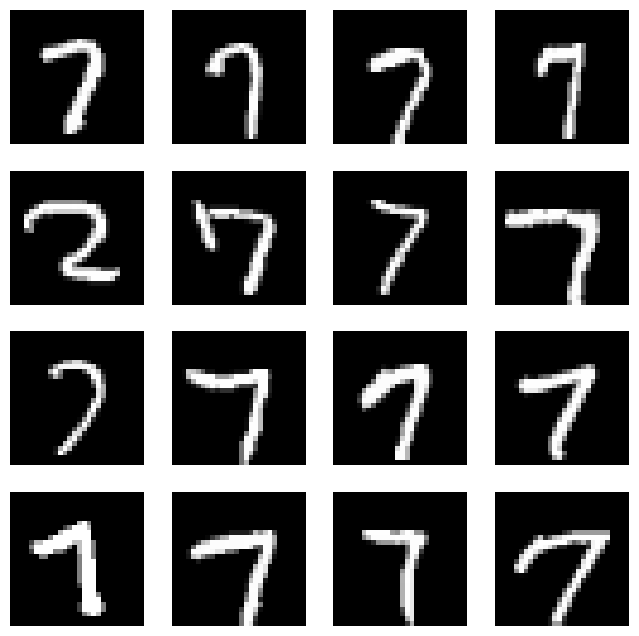

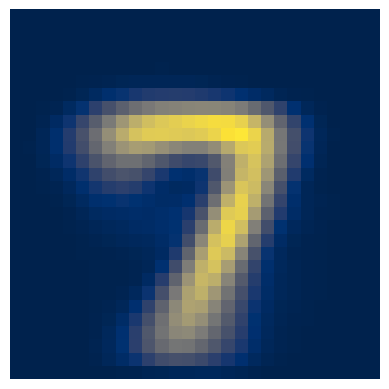

In [28]:
### visualize intersection of rules

ids = np.ones(len(X_train)).astype(bool)
for rv in rdict.values():    
    for r in rv:
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
imgs = X_train_raw[ids] 

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        index = i * 4 + j
        image = imgs[index]
        axes[i, j].imshow(image.squeeze(), cmap='gray')
        axes[i, j].axis('off')
plt.savefig(os.path.join(prefix,"tot_rule_samples_c"+str(c)+file_type),bbox_inches="tight")
plt.show()
plt.close()

avg_img = imgs.mean(axis=0).squeeze().numpy() 
    
### min-max normalization to highlight the higher value pixels 
avg_img = (avg_img-avg_img.min())/(avg_img.max()-avg_img.min()) 


plt.imshow(avg_img,vmin=0., vmax=1.,cmap="cividis")
plt.axis("off")
# plt.savefig(os.path.join(prefix,"tot_rule_avergae_c"+str(c)+file_type),bbox_inches="tight")
plt.show()
plt.close()

In [29]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [30]:
feature_names = ["z"+str(i) for i in range(X_train.shape[1])]

In [31]:
### otain rules for pred_y = c from a DecisionTreeClassifier

treemodel = DecisionTreeClassifier(max_depth=2,min_samples_leaf=4000,random_state=seed)
treemodel.fit(X_train,pred_y_train==c)

rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.numpy(),y_train,pred_y_train==c,np.arange(X_train.shape[-1]),feature_names,c=c)
len(rule_list)

3

In [32]:
print(export_text(treemodel))

|--- feature_44 <= 7.14
|   |--- feature_44 <= 5.92
|   |   |--- class: False
|   |--- feature_44 >  5.92
|   |   |--- class: False
|--- feature_44 >  7.14
|   |--- class: True



In [33]:
## print rules from DecisionTreeClassifier
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(44, '<=', 5.919)]
cond_prob_target 0.011 cond_prob_y 0.011 size 47723
z44 <= 5.919
#################
[(44, '<=', 7.141), (44, '>', 5.919)]
cond_prob_target 0.193 cond_prob_y 0.193 size 5496
z44 <= 7.141
z44 > 5.919
#################
[(44, '>', 7.141)]
cond_prob_target 0.689 cond_prob_y 0.687 size 6781
z44 > 7.141
